In [368]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import sys
from sklearn.datasets import load_svmlight_file

# Ridge regression problem

Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n (\langle a_i, x \rangle - y_i)^2 + \frac{\lambda}{2} \sum_{i=1}^n x_i^2 = 
\frac{1}{2 n} \| \mathbf{A} x - y \|_2^2 + \frac{\lambda}{2} \| x \|_2^2 
\to \min\limits_{x \in \mathbb{R}^d}
$$ 

In [369]:
def f_ridge(A, y, x, lambd):
    return la.norm(np.dot(A,x) - y)**2 / (A.shape[0] * 2.0) + la.norm(x)**2 * lambd / 2.0

$$
f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x),
$$ thus
$$
f_i(x) = \frac{1}{2} (A[i, :] x - y_i)^2 + \frac{\lambda}{2} \|x\|^2
$$

Solution to the optimization problem is:
$$
x^* = (A^T A + \lambda n I)^{-1} A^T y
$$

In [370]:
def solution(A, y, lambd):
    n = A.shape[0]
    d = A.shape[1]
    return np.dot(np.dot(la.inv(np.dot(A.T, A) + lambd * n * np.eye(d)), A.T), y)

Let
$$
f_v(x) = \frac{1}{n} \sum_{i=1}^n v_i f_i(x),
$$
where $\mathbb{E}(v)=1$

## SGD algorithm
$$
v^k \sim \cal{D} \\
x^{k+1} = x^k - \gamma^k \nabla f_{v^k} (x^k)
$$
Note that
$$
\nabla f_{v^k} (x^k) = \frac{1}{n} \sum_{i=1}^n v^k_i \nabla f_i(x^k)
$$
In our case, 
$$
\nabla f(x) = \frac{1}{n} A^T (Ax - y) + \lambda x,
$$
and
$$
\nabla f_i(x) = A[i, :]^T (A[i,:]x  - y_i) + \lambda x
$$


In [371]:
def grad_f_i(A, y, x, lambd, random_ind, batch_size=1):
    grad = np.dot(A[random_ind].T, (np.dot(A[random_ind], x) - y[random_ind])) + batch_size*lambd * x
    grad = grad/batch_size
    
    return grad

In [372]:
def construct_v_independent_sampling(probab):
    n = len(probab)
    v = []
    for i in range(0, n):
        rand = np.random.rand();
        if rand <= probab[i]:
            v.append(i)
    return v


def construct_tau_nice(n, tau):
    random_sample = np.random.choice(np.arange(n), tau, replace=False)
    return random_sample

In [373]:
def sgd(A, y, x0, x_star, lambd, probab, step_size, 
        epsilon=1e-6, max_epoch=100, seed=42, kind="proper", tau = 1):
    
    np.random.seed(seed)
    
    n = A.shape[0]
    d = A.shape[1]
    
    x = x0
    
    epoch_num = 0
    iter_num = 0
    
    n_batch = np.arange(n)
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_ridge(A, y, x, lambd)]
    
    while epoch_num < max_epoch and error[-1] > epsilon: 
        

        
        if (kind == "proper"):
            v = np.random.choice(n_batch, size=n, replace=True, p=probab)
            for i in range(n):
                rand_ind = v[i]
                x = x - step_size * grad_f_i(A, y, x, lambd, rand_ind)
                iter_num += 1
        elif (kind == "taunice"):
            v = construct_tau_nice(n, tau)
            x_new = x - step_size * grad_f_i(A, y, x, lambd, v, len(v))
            x = x_new
            iter_num += len(v)
        else:
            v = construct_v_independent_sampling(probab)
            if len(v) == 0:
                x = x
            else:
                x = x - step_size * grad_f_i(A, y, x, lambd, v, len(v))
            iter_num += len(v)
        

        
        if iter_num >= n :
            f = open("log.txt", "w+")
            f.write(str(epoch_num) + " error: " + str(error[-1]))
            f.close()
            epoch_num += 1
            iter_num = 0
            f_values.append(f_ridge(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)
    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

### Calculating constants

$$
L_i = \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\
\mu = \frac{1}{n} \lambda_{\text{min}}(\mathbf{A}^T \mathbf{A}) + \lambda
$$

In [374]:
def calculate_mu_and_L (A, lambd):
    n = A.shape[0]
    mu = min(abs(la.eigvals(np.dot(A.T,A)))) / n + lambd
    L = la.norm(A, axis=1, ord=2)**2 + lambd

    return mu, L

In our case M-smoothness:
$$
M_i = A[i] A[i]^T + \lambda I
$$

In [375]:
def calculate_M(A, lambd):
    n = A.shape[0]
    d = A.shape[1]
    M = [np.outer(A[i].T, A[i]) + lambd * np.eye(d) for i in range(n)]

    return M

$$
h_i = \| \nabla f_i(x^*) \|^2
$$

For proper & non-vacuous sampling
$$
\sigma^2 = \frac{1}{n^2} \sum_{i \in [n]} \frac{1}{p_i} h_i
$$
$$
\mathcal{L} = \frac{1}{n} \max_{i \in [n]} \frac{\lambda_{\max} (M_i)}{p_i}
$$

In [376]:
def calculate_h (A, y, x_star, lambd):
    n = A.shape[0]
    h = [la.norm(grad_f_i(A, y, x_star, lambd, i))**2 for i in range(n)]

    return h

In [377]:
def calculate_sigma2_proper (probab, h):
    n = len(probab)
    sig = 0
    for i in range(n):
        sig += (1 / probab[i]) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_proper (probab, M):
    n = len(probab)
    L = max([max(abs(la.eigvals(M[i])))/probab[i] for i in range(n)])
    L = L/n
    
    return L

For independent sampling where $\mathbb{E}(|S|) = \tau$
$$
\sigma^2 = \frac{1}{n^2} \sum_{i \in [n]} (\frac{1}{p_i}-1)  h_i   \\
\mathcal{L} := \mathcal{L}^i_{\text{max}} = \sum_{j \in [n]} \frac{\lambda_{\max}(M_j)}{n} + \max_{i \in [n]} (\frac{1}{p_i} - 1) \frac{\lambda_{max}(M_i)}{n} \\
$$

In [378]:
def calculate_sigma2_indepedent (probab, h):
    n = len(probab)
    sig = 0

    for i in range(n):
        sig += (1 / probab[i] - 1) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_indepedent (probab, M):
    L = 0
    n = len(probab)
    
    for i in range(n):
        L += max(abs(la.eigvals(M[i])))/n
    
    second_term = max([(1 / probab[i] - 1) * max(abs(la.eigvals(M[i])))/n for i in range(n)])
    L += second_term
    
    return L

For $\tau$-nice sampling, we have:
$$
\sigma^2 = \frac{1}{n \tau} \frac{n-\tau}{n-1} \sum_{i \in [n]} h_i
$$
$$
\mathcal{L} = \frac{1}{\tau} \frac{\tau-1}{n-1} \sum_{j \in [n]} \lambda_{\max} (M_j) + \frac{1}{\tau}(1-\frac{\tau-1}{n-1}) \max_{i \in [n]} \lambda_{\max} (M_i)
$$

In [379]:
def calculate_sigma2_taunice (h, tau):
    n = len(h)
    sig = 0

    for i in range(n):
        sig += h[i]
    sig = sig/(n*tau)*(n-tau)/(n-1)
    
    return sig

def calculate_L_cal_taunice (M, tau, n):
    L = 0

    for i in range(n):
        L += max(abs(la.eigvals(M[i])))/n
        
    L = L/tau*(tau-1)/(n-1)
    
    second_term = max([max(abs(la.eigvals(M[i]))) for i in range(n)])
    second_term = second_term/tau*(1-(tau-1)/(n-1))
    L += second_term
    
    return L

$$
p_i^{\mathcal{L}} = \frac{\lambda_{\max}(M_i)}{\sum_{j \in [n]} \lambda_{\max} (M_j)} \tau
$$

In [380]:
def calculate_prob_L(M, n, tau):
    pl = np.zeros(n)
    s = sum([max(abs(la.eigvals(M[i]))) for i in range(n)])
    over = set()
    below = set(range(n))

    for i in range(n):
        pl[i] = max(abs(la.eigvals(M[i]))) / s * tau
        if pl[i] == 1.0:
            below.discard(i)
        if pl[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = pl[ind] - 1
        length_of_rem = len(below)
        pl[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            pl[below_ind] += rem / length_of_rem
            if (pl[below_ind] > 1.0000000001):
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return pl

$$
p^{\sigma^2}_{i} = \frac{\sqrt{h_i}}{\sum_{j \in [n]} \sqrt{h_j}} \tau
$$

In [381]:
def calculate_prob_sigma(h, n, tau):
    ps = np.zeros(n)
    s = sum([abs(np.sqrt(h[i])) for i in range(n)])
    over = set()
    below = set(range(n))
    
    for i in range(n):
        ps[i] = np.sqrt(h[i]) / s * tau
        if ps[i] == 1.0:
            below.discard(i)
        if ps[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = ps[ind] - 1
        length_of_rem = len(below)
        ps[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            ps[below_ind]+= rem / length_of_rem
            if ps[below_ind] > 1.0000000001:
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return ps

In [382]:
def calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu):
    a = 2 * (sum([np.sqrt(h[i]) for i in range(n)])/n)**2 / (epsilon * mu * sum([max(abs(la.eigvals(M[i]))) for i in range(n)])/n)
#     print(a)
    alpha = (tau - a - 1 + np.sqrt(4 * tau + (tau - a - 1)**2)) / (2 * tau)
    
    pl = calculate_prob_L(M, n, int(alpha*tau))
    ps = calculate_prob_sigma(h, n, int((1-alpha)*tau))
    
#     print(alpha)
    p_opt =  pl +  ps
    
    return p_opt

In [383]:
def calculate_optimal_prob_proper(M, h, n, epsilon, mu):
    pl = calculate_prob_L(M, n, 1)
    ps = calculate_prob_sigma(h, n, 1)
    L_opt = sum([max(abs(la.eigvals(M[i]))) for i in range(n)])/n
    sig2_opt = (sum([abs(np.sqrt(h[i])) for i in range(n)])/n)**2
    print(sig2_opt)
    alpha = epsilon*mu*L_opt/(2*sig2_opt+epsilon*mu*L_opt)
    print(alpha)
    p_opt = alpha * pl + (1 - alpha) * ps
    
    return p_opt

In [384]:
def calculate_stepsize(L_cal, epsilon, mu, sigma2):
    gamma = min(1 / (2 * L_cal), epsilon * mu / (4 * sigma2))

    return gamma

In [385]:
def calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n):
    k = max(2 * L_cal / mu, 4 * sigma2 / (epsilon * mu**2)) * np.log(2 * la.norm(x0 - x_star)**2 / epsilon)
    return k/n

In [386]:
def calculate_tau_star_independent(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    t = n*(2/(mu*epsilon)*h_bar - L_max)/(2/(mu*epsilon)*h_bar - L_max + sum(L))
    return t
    

In [387]:
def calculate_tau_star_taunice(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    L_bar = sum(L)/n
    
    t = n*(L_bar - L_max + 2/(mu*epsilon)*h_bar)/(n*L_bar - L_max + 2/(mu*epsilon)*h_bar)
    return t
    

## Data

In [482]:
np.random.seed(1)

# n = 500
# d = 50

# A = np.random.normal(size=(n,d))
# y = np.random.normal(size=n)
# lambd = 50 / n

# tau = int(n/10)

# epsilon = 0.001

# x0 = np.random.normal(size=d)



# x_star = solution(A, y, lambd)
# mu, L = calculate_mu_and_L(A, lambd)
# M = calculate_M(A, lambd)
# h = calculate_h(A, y, x_star, lambd)



# Real Data
def get_data():
    data = load_svmlight_file("/home/sailana/Desktop/Real_dataset/bodyfat")
    return data[0], data[1]

A, y = get_data()

A = A.todense()
A = np.array(A)
A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)
n = A.shape[0]
d = A.shape[1]

lambd = 10/n

tau = int(n/10)

epsilon = 0.001

x0 = np.random.normal(size=d)

x_star = solution(A, y, lambd)
mu, L = calculate_mu_and_L(A, lambd)
M = calculate_M(A, lambd)
h = calculate_h(A, y, x_star, lambd)




In [483]:
print(n, d)

252 14


In [484]:
epoch_num = 6000

## Proper, non-vacuous sampling

In [485]:
probab_uniform = np.ones(n)/n
L_cal = calculate_L_cal_proper(probab_uniform, M)
sigma2 = calculate_sigma2_proper(probab_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 38.1094361146142
Stepsize: 0.028322908600328277


In [486]:
x_opt_proper, f_val_proper, x_err_proper = sgd(A, y, x0, x_star, lambd, probab_uniform, step_size, 
                          epsilon=epsilon, max_epoch=epoch_num, kind="proper")

Number of epochs: 18
Error: 0.0007244271330537417



#### Proper, non-vacuous sampling, Importance

In [487]:
p_proper_opt = calculate_optimal_prob_proper(M, h, n, epsilon, mu)
L_cal = calculate_L_cal_proper(p_proper_opt, M)
sigma2 = calculate_sigma2_proper(p_proper_opt, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

0.00024607017226876396
0.07735349398521836
Expected number of epochs: 26.877980662655617
Stepsize: 0.040158153599088975


In [488]:
x_opt_proper_importance, f_val_proper_importance, x_err_proper_importance = sgd(A, y, x0, x_star, lambd, 
                                p_proper_opt, step_size, epsilon=epsilon, max_epoch=epoch_num, kind="proper")

Number of epochs: 12
Error: 0.0009818625469558801



## Independence Sampling

In [489]:
p_uniform = np.ones(n)/n*tau
L_cal = calculate_L_cal_indepedent(p_uniform, M)
sigma2 = calculate_sigma2_indepedent(p_uniform, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 2.3252742544062968
Stepsize: 0.4641904385424244


In [490]:
x_opt_indep, f_val_indep, x_err_indep = sgd(A, y, x0, x_star, lambd, p_uniform, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 26
Error: 0.0007718191470966515



#### Independence, importance

In [491]:
p_optimal = calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu)
L_cal = calculate_L_cal_indepedent(p_optimal, M)
sigma2 = calculate_sigma2_indepedent(p_optimal, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 2.3977375487020187
Stepsize: 0.4501618938522147


In [492]:
x_opt_indep_importance, f_val_indep_importance, x_err_indep_importance = sgd(A, y, x0, x_star, lambd, p_optimal, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 25
Error: 0.0007530415633338679



#### Independent, uniform with optimal minibatch

In [493]:
tau_star = calculate_tau_star_independent(h, L, n, mu, epsilon)
tau_star = int(tau_star)
p_uniform_tau = np.ones(n)/n*tau_star
L_cal = calculate_L_cal_indepedent(p_uniform_tau, M)
sigma2 = calculate_sigma2_indepedent(p_uniform_tau, h)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 2.389401153217876
Stepsize: 0.45173246628371655


In [494]:
x_opt_indep_tau, f_val_indep_tau, x_err_indep_tau = sgd(A, y, x0, x_star, lambd, p_uniform_tau, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="independent")

Number of epochs: 16
Error: 0.0007899616816324767



#### $\tau$-nice sampling

In [495]:
p_uniform_tau = np.ones(n)/n*tau
L_cal = calculate_L_cal_taunice(M, tau, n)
sigma2 = calculate_sigma2_taunice(h, tau)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

Expected number of epochs: 1.3786202387278763
Stepsize: 0.7829350284892509


In [496]:
x_opt_taunice, f_val_taunice, x_err_taunice = sgd(A, y, x0, x_star, lambd, p_uniform_tau, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="taunice", tau=tau)

Number of epochs: 15
Error: 0.0005348186666069768



#### $\tau$-nice with optimal $\tau$

In [497]:
taunice_opt = int(calculate_tau_star_taunice(h, L, n, mu, epsilon))
print(taunice_opt)
# taunice_opt = n
L_cal = calculate_L_cal_taunice(M, taunice_opt, n)
sigma2 = calculate_sigma2_taunice(h, taunice_opt)
step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
epoch_n = calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n)
print("Expected number of epochs:", epoch_n)
print("Stepsize:", step_size)

15
Expected number of epochs: 2.398920679724719
Stepsize: 0.4499398771317973


In [498]:
x_opt_taunice_taustar, f_val_taunice_taustar, x_err_taunice_taustar = sgd(A, y, x0, x_star, lambd, np.ones(n)/n, step_size,
                             epsilon=epsilon, max_epoch=epoch_num, kind="taunice", tau=taunice_opt)

Number of epochs: 17
Error: 0.0005733539362772274



In [499]:
from matplotlib.pyplot import figure

In [500]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 15
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 21#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 28#36
plt.rcParams['axes.labelsize'] = 28#24

plt.rc('text', usetex=True)

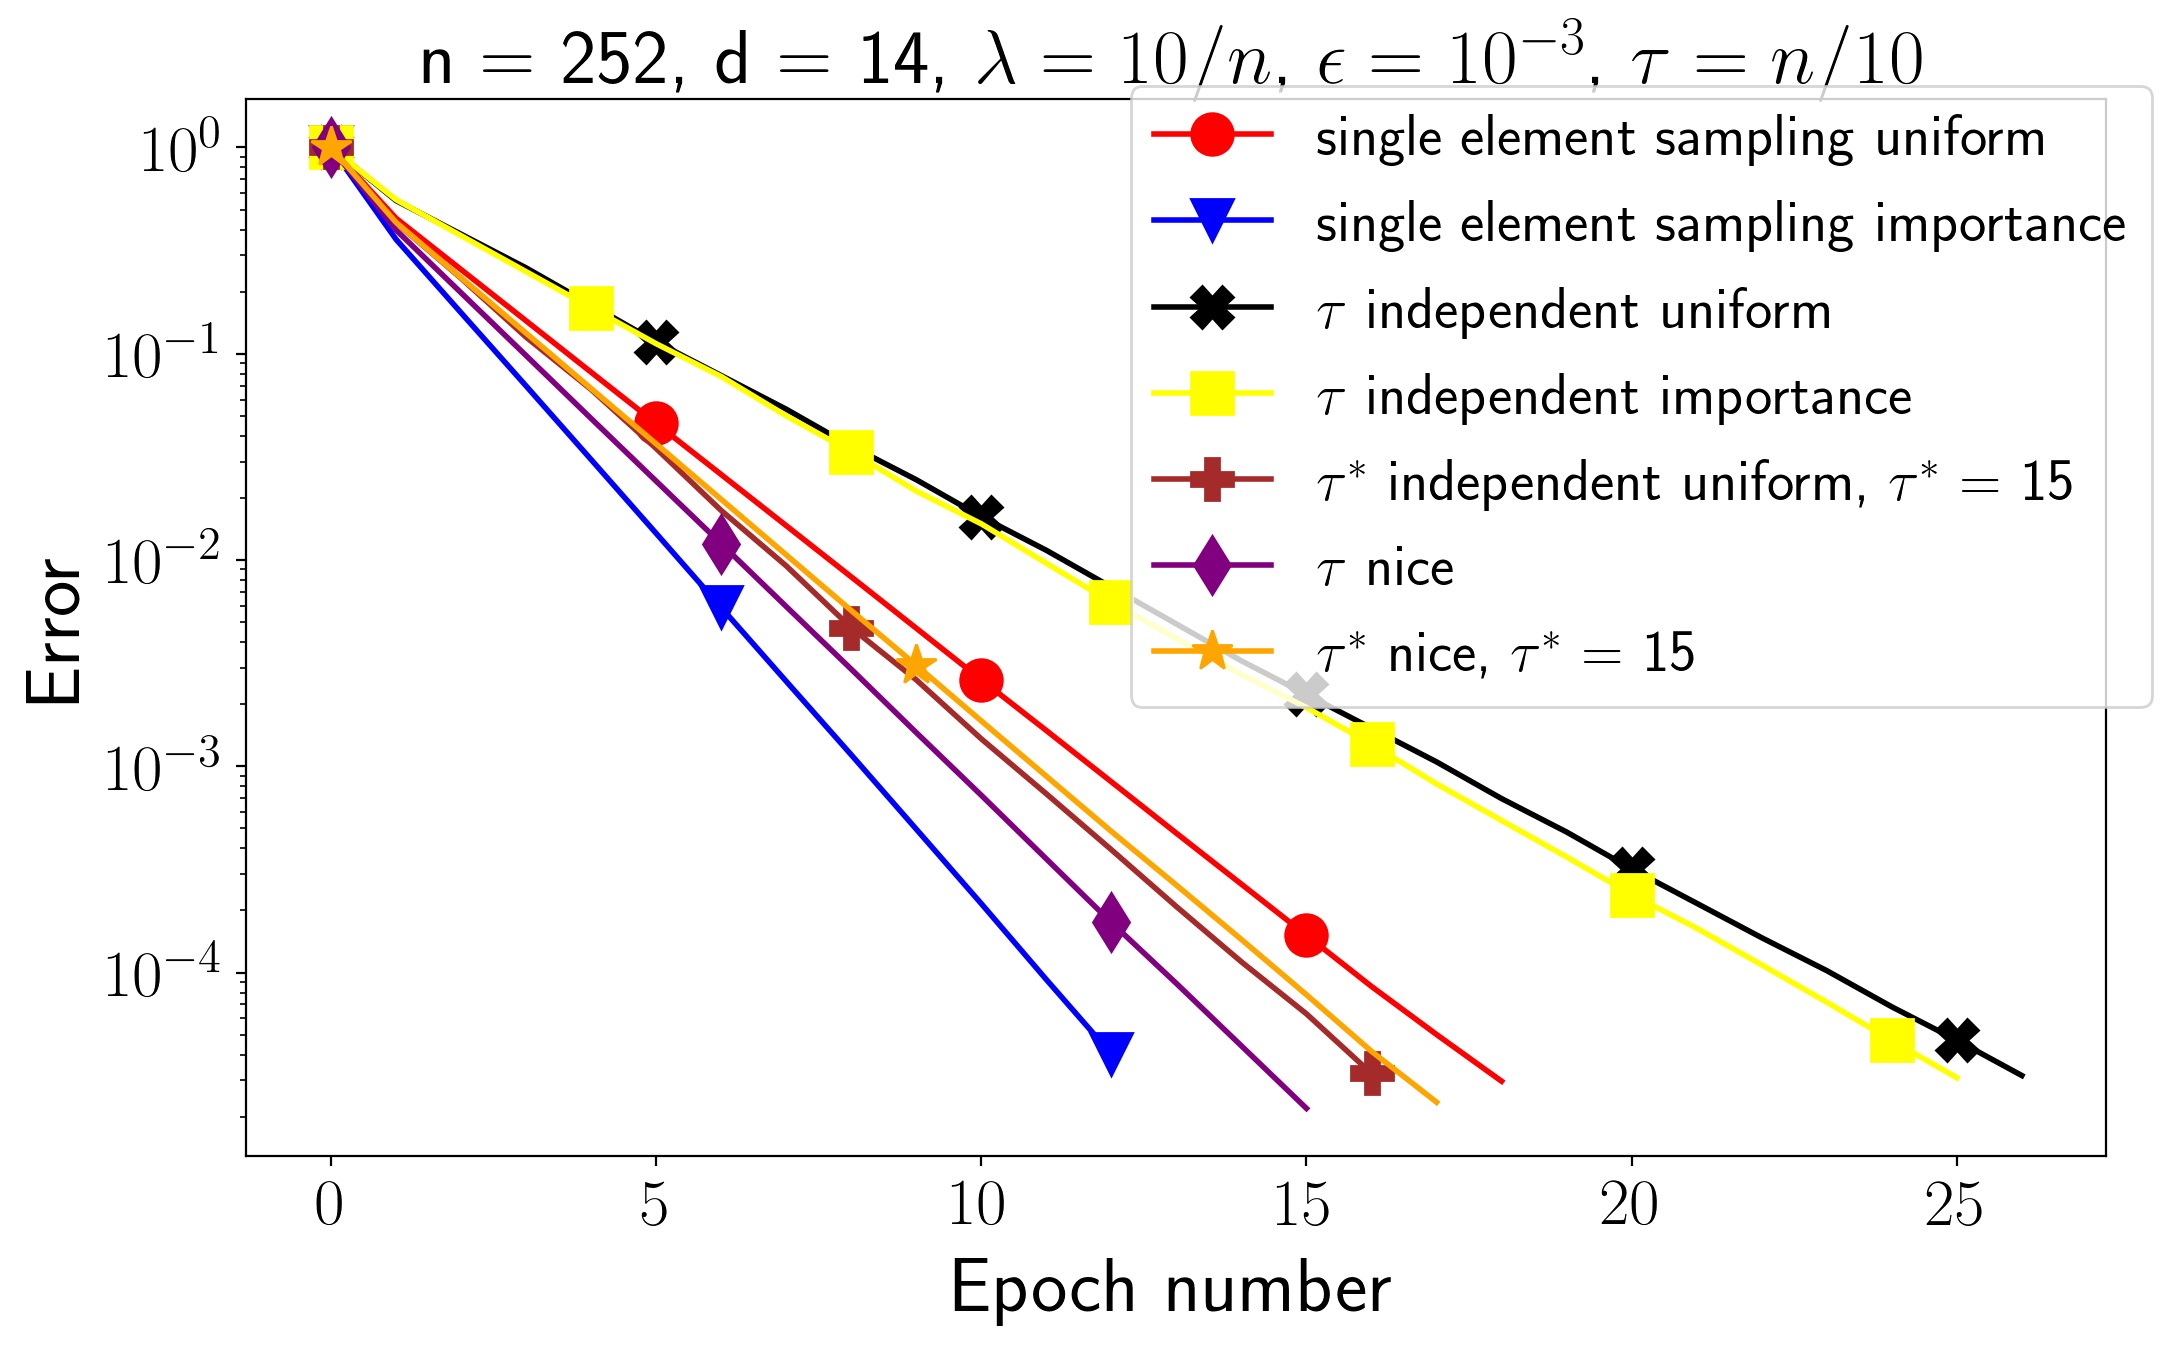

In [502]:
show_range = 6000

figure(num=None, figsize=(12, 7), dpi=200, facecolor='w', edgecolor='k')
plt.semilogy(x_err_proper[0:show_range]/la.norm(x0-x_star)**2, color = 'r',
             marker='o', markevery=5, linewidth=2,
             label=r"single element sampling uniform")
plt.semilogy(x_err_proper_importance[0:show_range]/la.norm(x0-x_star)**2, color = 'blue', 
             marker='v', markevery=6, linewidth=2,
             label=r"single element sampling importance")
plt.semilogy(x_err_indep[0:show_range]/la.norm(x0-x_star)**2, color = 'black', 
             marker='X', markevery=5, linewidth=2,
             label=r"$\tau$ independent uniform")
plt.semilogy(x_err_indep_importance[0:show_range]/la.norm(x0-x_star)**2, color = 'yellow', 
             marker='s', markevery=4, linewidth=2,
             label=r"$\tau$ independent importance")
plt.semilogy(x_err_indep_tau[0:show_range]/la.norm(x0-x_star)**2, color = 'brown', 
             marker='P', markevery=8, linewidth=2,
             label=r"$\tau^*$ independent uniform, $\tau^*$ = %d " %tau_star)
plt.semilogy(x_err_taunice[0:show_range]/la.norm(x0-x_star)**2, color = 'purple', 
             marker='d', markevery=6, linewidth=2,
             label=r"$\tau$ nice ")
plt.semilogy(x_err_taunice_taustar[0:show_range]/la.norm(x0-x_star)**2, color = 'orange', 
             marker='*', markevery=9, linewidth=2,
             label=r"$\tau^*$ nice, $\tau^*$ = %d " %taunice_opt)





plt.legend(loc='upper right', bbox_to_anchor=(1.04, 1.04))
# plt.grid()
plt.title(r"n = %d, d = %d, $\lambda = 10/n$, $\epsilon=10^{-3}$, $\tau = n/10$" %(n,d))
plt.xlabel("Epoch number")
plt.ylabel(r"Error")
plt.savefig("n%d_d%d_all_ridge_real_bodyfat_5graphs.pdf" %(n,d))
plt.show()


In [35]:
t = np.arange(2, n-1, 20)
st_s = []
for t_bat in t:
    L_cal = calculate_L_cal_taunice(M, t_bat, n)
    sigma2 = calculate_sigma2_taunice(h, t_bat)
    step_size = calculate_stepsize(L_cal, epsilon, mu, sigma2)
    st_s.append(step_size)

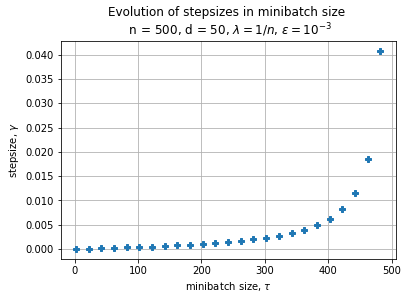

In [36]:
plt.plot(t, st_s, 'P')


plt.grid()
plt.title("Evolution of stepsizes in minibatch size \n n = %d, d = %d, $\lambda = 1/n$, $\epsilon=10^{-3}$" %(n,d))
plt.xlabel(r"minibatch size, $\tau$")
plt.ylabel(r"stepsize, $\gamma$")
plt.savefig("n%d_d%d_stepsize_minibatch.pdf" %(n,d))


plt.show()


## Real Data